# CarDEC Demonstration Notebook

This notebook implements CarDEC: $\underline{\textbf{C}}$ount $\underline{\textbf{a}}$dapted $\underline{\textbf{r}}$egularization for $\underline{\textbf{D}}$eep $\underline{\textbf{E}}$mbedded $\underline{\textbf{C}}$lustering.

CarDEC is a method for joint clustering and denoising of single cell rna-sequencing data. CarDEC is a model that can denoise all genes in a dataset including both highly variable and lowly variable genes, while also providing state of the art clustering accuracy. Critically, the inclusion of a clustering loss regularizes the denoising process, removing batch effects from the denoised counts.

Here, we will demonstrate CarDEC on the Macaque retina dataset. This dataset has very complex batch effects: with batches sequenced from four different Macaques at different regions of the retina, and with additional samples sequenced at different times.

## Architecture Overview

The CarDEC Architecture is displayed below. Training of CarDEC is folded into two steps.

In the first step, an autoencoder with a mean squared error loss is pretrained on the high variance genes of the dataset. Once pretraining is complete, we introduce cluster centroids and a clustering loss, and also introduce extra layers to perform mean square driven reconstruction of low variance genes. Highly variable and lowly variable features are fed into separate, symmetric encoders. This architectural design ensures that the lower variance features do not debilitate CarDEC's ability to cluster genes, while improving denoising results on the lower variance features. 

To ensure that we obtain high quality clustering, the cluster membership probabilities are permitted to functionally depend only on the embedding layer of the highly variable gene encoder. Likewise, I ensure that the denoising of highly variable genes is high quality by allowing the layers of the highly variable gene decoder to depend only on the highly variable gene encoder's embedding layer. Furthermore, when we pretrain the autoencoder, we do so using only the highly variable features. No lowly variable features are used during pretraining.

To improve denoising results on lowly variable features, we make a special adjustment for the low variance features decoder. Rather than taking as input for this decoder only the embedding layer of the low variance features encoder, we concatenate the embedding layers of the highly variable and lowly variable feature encoders together, and then use this combined embedding as input to the decoder for low variance features. This allows the model to exploit the batch corrected embedded representation of high variance features when denoising the low variance features while not compromising clustering or denoising for high variance features, dramatically improving the quality of low variance gene counts for downstream analysis.

Note that naturally the denoised features are on the normalized zscore scale. If our data are read counts, then the user may want access to denoised and batch corrected genewise features on the count scale, rather than on the zscore standardized scale. Having these denoised expression values on the count scale is useful for certain downstream analyses.

We produce denoised features on the count scale by maximizing a negative binomial likelihood using auxialiary deep learning models that take the semantically enriched, batch corrected embeddings from CarDEC as input. One model is used to obtain counts for high variance genes, and a second model is used to obtain counts for low variance genes if they are also modeled. For the high variance count network, we maximize the negative binomial likelihood using the low dimensional embedding of high variance genes from CarDEC as input. For the low variance count network, we maximize the negative binomial likelihood using the low dimensional embeddings of both high variance genes and low variance genes from CarDEC as input. These count models are not connected architecturally to the main CarDEC model, they are merely auxiliary models which use the low dimensional embeddings from CarDEC as input and provide denoised expression values on the count scale. They are depicted below the main CarDEC model.

We explore the performance of this architecture in this notebook.

## Pretrained Autoencoder
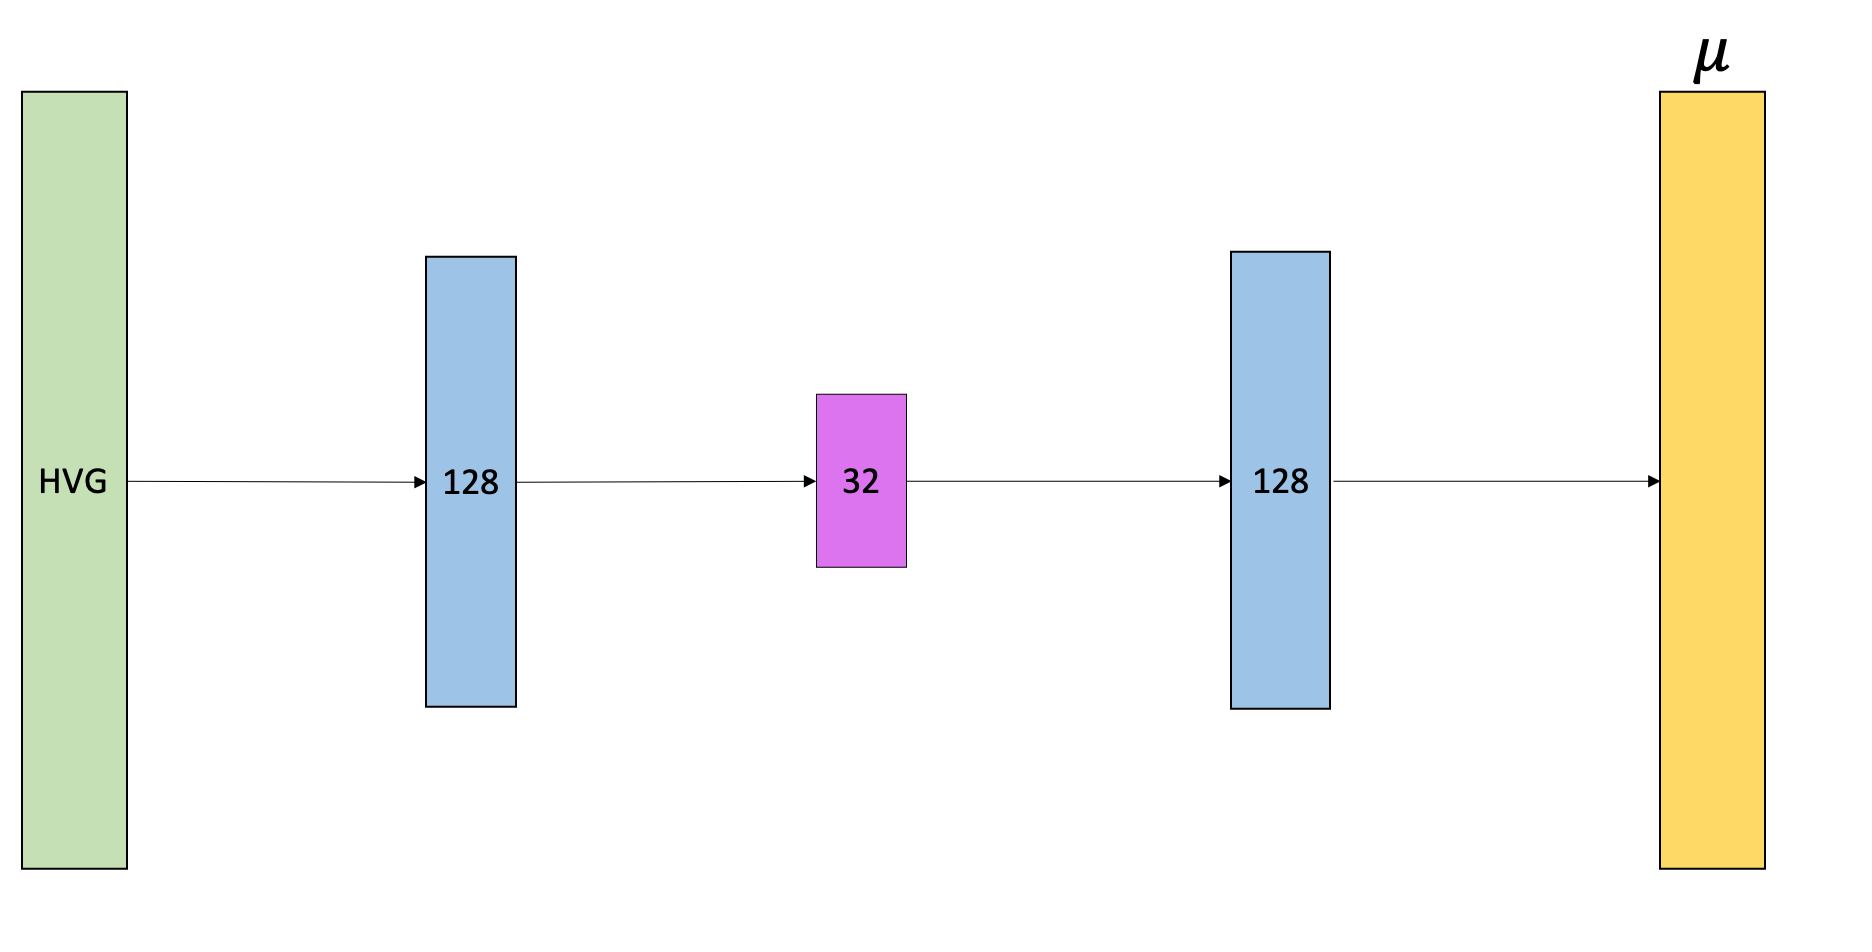
## Main CarDEC Model
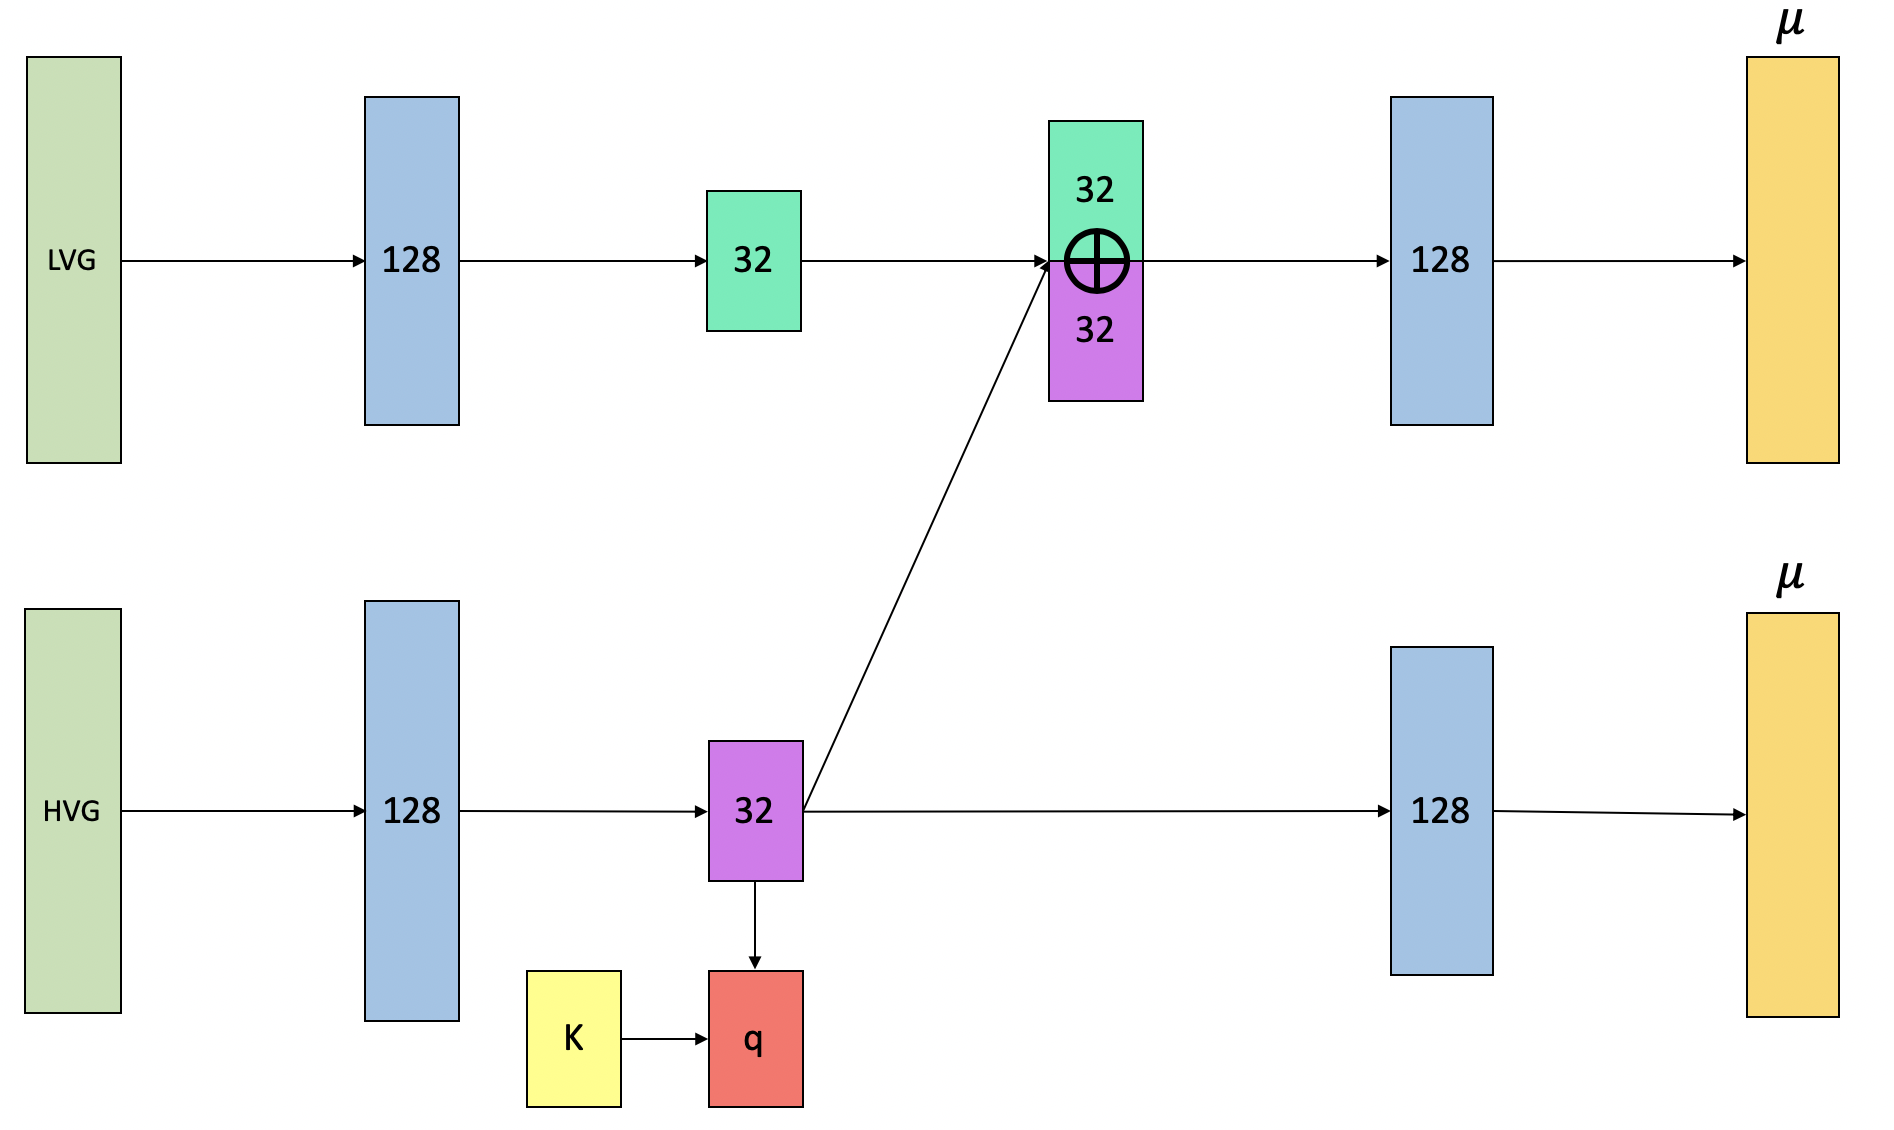
## Count Networks
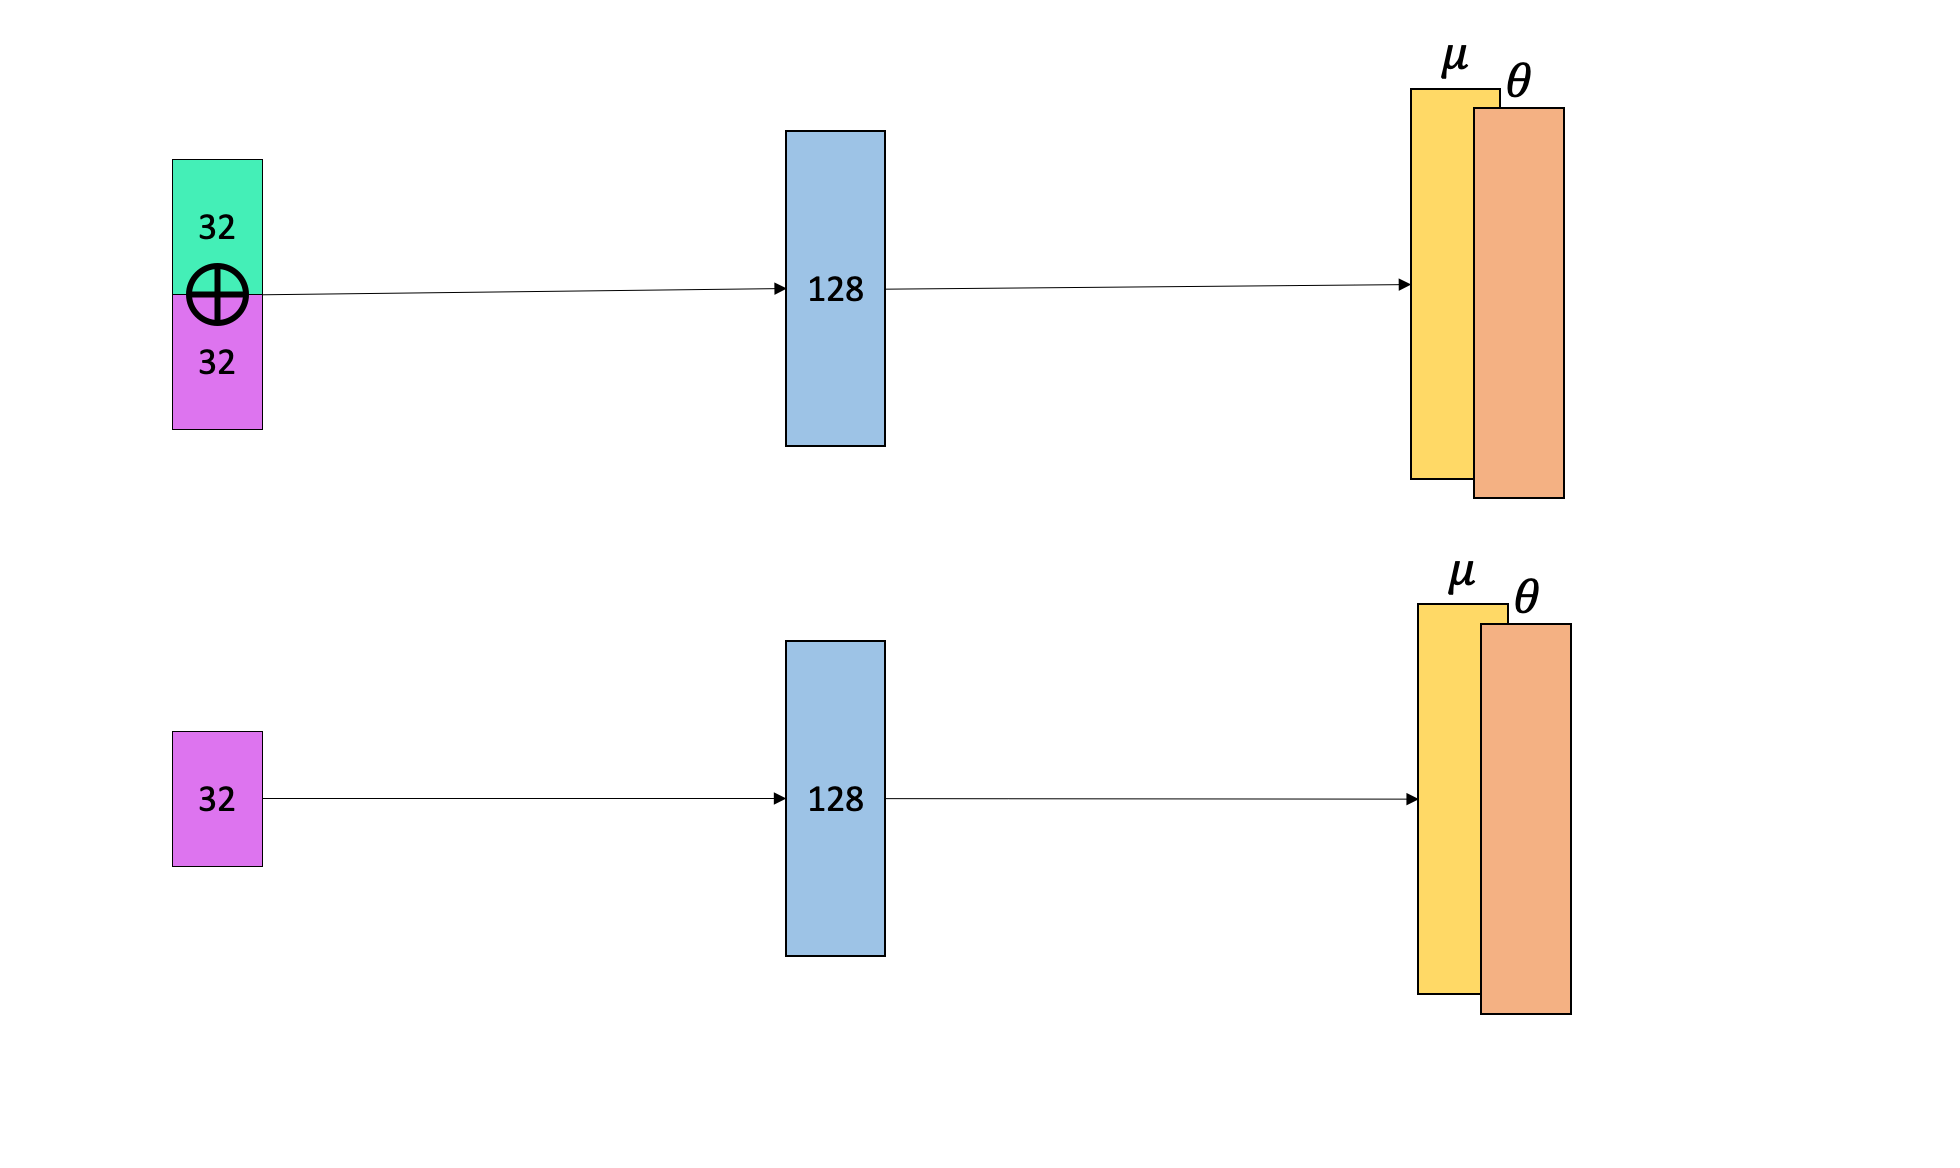

## Analysis Preparation

Here, we prepare for analysis. We import requisite packages and define helper functions.

In [1]:
"""Broadly useful python packages"""
import pandas as pd
import os
import numpy as np
import pickle
from copy import deepcopy
from shutil import move
import warnings

"""Machine learning and single cell packages"""
import sklearn.metrics as metrics
from sklearn.metrics import adjusted_rand_score as ari, normalized_mutual_info_score as nmi
import scanpy as sc
from anndata import AnnData
import seaborn as sns

"""CarDEC"""
from CarDEC import CarDEC_API

%matplotlib inline

In [2]:
"""Miscellaneous useful functions"""

def read_macaque(path,cache=True):
    """A function to read and preprocess the macaque data"""
    adata = sc.read(path)
    sc.pp.filter_cells(adata, min_genes = 200)
    sc.pp.filter_genes(adata, min_cells = 30)

    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata = adata[adata.obs['n_genes'] < 2500, :]
    print(adata)
    
    return(adata)

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    vector_strings = list(vector)
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    subdirs = [x for x in subdirs if os.path.basename(x) != '..']

    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)
    
def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 12:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

metrics_ = [ari, nmi, purity_score]

Now, let's read the data in, and take a look at the cell type distribution.

View of AnnData object with n_obs × n_vars = 30298 × 18083
    obs: 'batch', 'sample', 'macaque_id', 'nGene', 'nTranscripts', 'cluster', 'region', 'class', 'n_genes', 'n_counts'
    var: 'n_cells'


/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


The number of cells of type: BB/GB* is 1814
The number of cells of type: DB1 is 995
The number of cells of type: DB2 is 2243
The number of cells of type: DB3a is 623
The number of cells of type: DB3b is 2640
The number of cells of type: DB4 is 2985
The number of cells of type: DB5* is 3467
The number of cells of type: DB6 is 658
The number of cells of type: FMB is 4500
The number of cells of type: IMB is 6150
The number of cells of type: OFFx is 147
The number of cells of type: RB is 4076


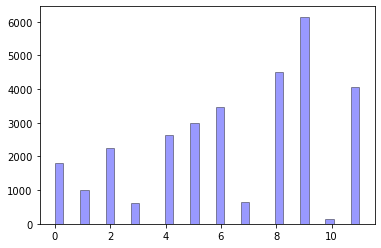

In [3]:
adata = read_macaque("/Users/xiaokangyu/Desktop/STAGATE_Denosing/carDEC_tf/Data/macaque/macaque_bc.h5ad", cache = True)

celltype = adata.obs['cluster'].values
celltype_vec = convert_vector_to_encoding(celltype)

sns.distplot(celltype_vec, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

celltype_key = np.unique(adata.obs['cluster'].values)
for type_ in celltype_key:
    ntype = sum([x == type_ for x in celltype])
    print("The number of cells of type: " + type_ + " is " + str(ntype))

## Figure Data

In [4]:
ARI_data = {'ARI': [0]*1,
            'NMI': [0]*1,
            'Purity': [0]*1,
           'Method': ['CarDEC']}
ARI_data = pd.DataFrame(ARI_data)

ARI_data_gene = {'ARI': [0]*4,
            'NMI': [0]*4,
            'Purity': [0]*4,
           'Method': ['CarDEC'] * 2 + ['Raw']*2,
                'Type': ['HVG', 'LVG'] *2}
ARI_data_gene = pd.DataFrame(ARI_data_gene)

ARI_raw = {'ARI': [0]*2,
            'NMI': [0]*2,
            'Purity': [0]*2,
                'Type': ['HVG', 'LVG']}
ARI_raw = pd.DataFrame(ARI_raw)

figure_path = "../Figures/macaque"
figure_path_supplement = "../Figures/macaque_supplement"
figure_path_embedding = "../Figures/macaque_embedding"

build_dir(figure_path)
build_dir(figure_path_supplement)
build_dir(figure_path_embedding)

## Analyze the data with CarDEC

First initialize the CarDEC class. Doing so will preprocess the data. When normalizing the data, we need to decide how many of the most variable genes should be deemed "highly variable." High variance genes drive clustering, so a reasonably stringent cutoff to deem a gene highly variable is important to getting high quality clusters in some datasets.

Here, I retain the top 2000 highly variable genes as designated HVGs for driving cluster assignments. Highly variable genes are selected with Scanpy using the "Seurat" selection flavor. All other genes are retained as low variance genes to be fed into the low variance encoder of the CarDEC Model.

The data we are working with will be stored as an annotated dataframe in the dataset attribute of the CarDEC API object. The main array, accessible via CarDEC.dataset.X, is the original count data. CarDEC.dataset will also inherit observation and variable metadata from the adata object. This metadata is accessible via CarDEC.dataset.obs and CarDEC.dataset.var respectively. CarDEC.dataset.var["Variance Type"] identifies which genes are treated as high variance features and which genes are treated as low variance features.

In [5]:
CarDEC = CarDEC_API(adata, weights_dir = "Macaque All/CarDEC_LVG Weights", batch_key = "sample", LVG = True, n_high_var = 2000)

/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:249: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_counts'] = number
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be 

/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Re

Now, let's build the CarDEC model in TensorFlow by calling CarDEC.build_model. Doing so will initialize the high variance feature autoencoder. By default, the CarDEC API will try to load the weights for this autoencoder from the weights directory. If the weights cannot be found, then the autoencoder will be trained from scratch with automatic differentiation, and its weights will be saved.

We use the mean squared error noise model as the loss of our autoencoder since this noise distribution is very flexible and adaptable to different data modalities (UMI and non-UMI datasets, among others). We will set the cluster weight to be 1, which will weight the clustering loss and reconstruction loss equally during the cluster refinement step.

In [6]:
CarDEC.build_model(n_clusters = 11)


-----------------------CarDEC Architecture-----------------------


--------------------Encoder Sub-Architecture--------------------

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [1, 1, 128]         256,128
              ReLU-2                [1, 1, 128]               0
            Linear-3                 [1, 1, 32]           4,128
              Tanh-4                 [1, 1, 32]               0
Total params: 260,256
Trainable params: 260,256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.99
Estimated Total Size (MB): 1.00
----------------------------------------------------------------

------------------Base Decoder Sub-Architecture------------------

----------------------------------------------------------------
        Layer (type)          

Now we will make inference on the dataset with the CarDEC model. By default the CarDEC API will attempt to load the weights for the full CarDEC model from the weights directory. If the weights cannot be found, then the main CarDEC model will be trained from scratch with automatic differentiation, and its weights will be saved.

Once the weights for the full CarDEC model are initialized, the API will use the model to make inference on the data. This will add several outputs to CarDEC.dataset

layers: 
    1. ["denoised"] contains denoised batch corrected features in the gene space. These features are useful for downstream analyses in the gene expression space, like differential expression analysis.

obsm: 
    1. ["cluster memberships"] an array, where element (i,j) is the probability that cell i is in cluster j
    2. ["precluster denoised"] an array, where element (i,j) is the denoised expression value of high variance gene j in cell i. This denoised representation is avalible only for high variance genes.
    3. ["embedding"] the low-dimension embedding corresponding to high variance features (after fine tuning)
    4. ["LVG embedding"] the combined low-dimension embedding (more precisely, the embedding from the high variance encoder concatenated to the embedding from the low variance encoder). This axis array will be created ONLY if 
    low variance genes are modeled.
    5. ["precluster embedding"] the low-dimension embedding corresponding to high variance features (before fine 
    tuning)
    6. ["initial assignments"] the cluster assignments before finetuning. These assignments are identified only if the autoencoder is trained from scratch. If the autoencoder weights are loaded instead of trained from scratch, this vector will be set to all zeros.

In [7]:
CarDEC.make_inference()

CarDEC Model Weights not detected. Training full model.

ite=0
Iter 000 Loss: [Training: 0.967, Validation Cluster: 0.946, Validation AE: 0.916], Label Change: 1.000, Time: 86.9 s
ite=1
Iter 001 Loss: [Training: 1.048, Validation Cluster: 0.996, Validation AE: 0.917], Label Change: 0.003, Time: 84.4 s
ite=2
Iter 002 Loss: [Training: 1.141, Validation Cluster: 1.074, Validation AE: 0.919], Label Change: 0.002, Time: 110.5 s
ite=3
Iter 003 Loss: [Training: 1.200, Validation Cluster: 1.148, Validation AE: 0.920], Label Change: 0.001, Time: 83.8 s

Decaying Learning Rate to: 3.3333333333333335e-05
ite=4
Iter 004 Loss: [Training: 1.219, Validation Cluster: 1.209, Validation AE: 0.921], Label Change: 0.000, Time: 89.7 s
ite=5
Iter 005 Loss: [Training: 1.215, Validation Cluster: 1.208, Validation AE: 0.921], Label Change: 0.000, Time: 228.3 s
ite=6
Iter 006 Loss: [Training: 1.211, Validation Cluster: 1.205, Validation AE: 0.921], Label Change: 0.000, Time: 99.3 s

Decaying Learning Rate to: 1

To obtained denoised counts, the user can call CarDEC.model_counts. The resultant denoised counts are added as a layer: CarDEC.dataset.layers['denoised counts']. If the keep_dispersion argument for CarDEC.model_counts is set equal to true, then dispersions for the negative binomial likelihood will also be added as a layer: CarDEC.dataset.layers["dispersion"].

In [8]:
CarDEC.model_counts()

----------Count Model HVG Count Architecture----------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [1, 1, 2000]         258,000
           MeanAct-2               [1, 1, 2000]               0
Total params: 258,000
Trainable params: 258,000
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.98
Estimated Total Size (MB): 1.02
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [1, 1, 2000]         258,000
           DispAct-2               [1, 1, 2000]               0
Total params: 258,000
Trainable params: 258,000
Non-trainable params: 0
------------------------------------------

## Evaluating Cell Clustering

First, let us evaluate the cluster assignments of CarDEC. For each cell, we get its most probable cluster by finding which membership probability is maximized. We visualize the clusters by computing the UMAP representation of CarDEC's bottleneck embedding space.

To evaluate cluster assignments, we compute adjusted rand index (ARI), normalized mutual information (NMI), and purity. Visually, the UMAP representation of the embedding space is colored by CarDEC's predicted cluster assignment, gold standard experimentally determined cell type, batch by sample ID, and batch by Macaque ID. Our hope is that clusters are separated by cell type, CarDEC cluster predictions recover true cell types, and that batches are mixed. Indeed, we see high clustering accuracy, and batch effect is successfully removed in the low dimensional space.

CarDEC Clustering Results
ARI = 0.9759
NMI = 0.9616
Purity = 0.9847


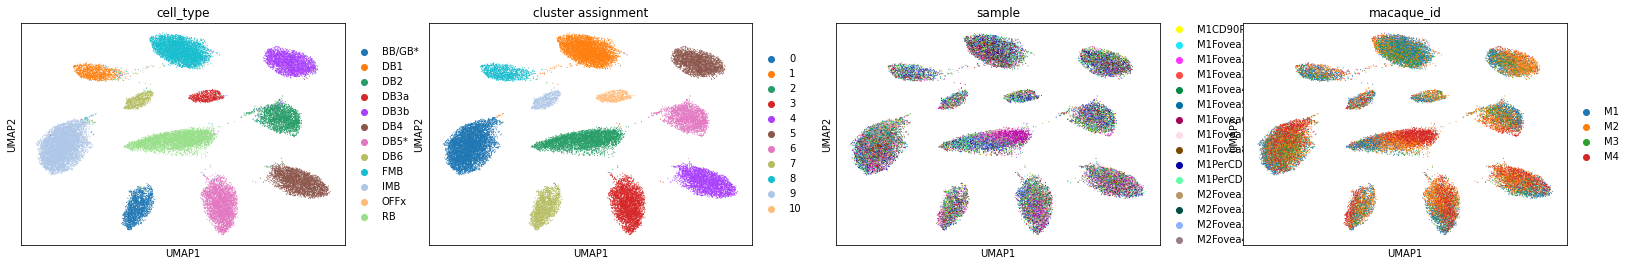

In [9]:
"""Assessing finetuned cluster assignments"""

temporary = AnnData(CarDEC.dataset.obsm['embedding'])
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

q = CarDEC.dataset.obsm['cluster memberships']
labels = np.argmax(q, axis=1)
temporary.obs['cluster assignment'] = [str(x) for x in labels]

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

"""Figure info for paper"""
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Region'] = temporary.obs['region'].values
DF['Macaque'] = temporary.obs['macaque_id'].values
DF['Sample'] = temporary.obs['sample'].values
DF['Cell Type'] = temporary.obs['cluster'].values
DF.index = temporary.obs.index

base_path = 'CarDEC.csv'
path = os.path.join(figure_path_embedding, base_path)

DF.to_csv(path)

"""Figure info for paper"""

ARI_data.iloc[0,:3] = ARI, NMI, Purity
ARI_data.to_csv(os.path.join(figure_path, 'ARIsummary.csv'))
ARI_data.to_csv(os.path.join(figure_path_supplement, 'ARIsummary.csv'))
ARI_data.to_csv(os.path.join(figure_path_embedding, 'ARIsummary.csv'))

Now, let's compute the same metrics and visualizations for the pretrained autoencoder embedding. Since the pretrained autoencoder doesn't have cluster assignments, we compute these ourselves by running Louvain's algorithm on the pretrained autoencoder's embedding.

We see that the pretrained autoencoder also has very good clustering results when we set the number of clusters to 11, although numerical metrics are a somewhat worse as compared to the full CarDEC model. 

CarDEC Pretrained Clustering Results
ARI = 0.9642
NMI = 0.9499
Purity = 0.9812


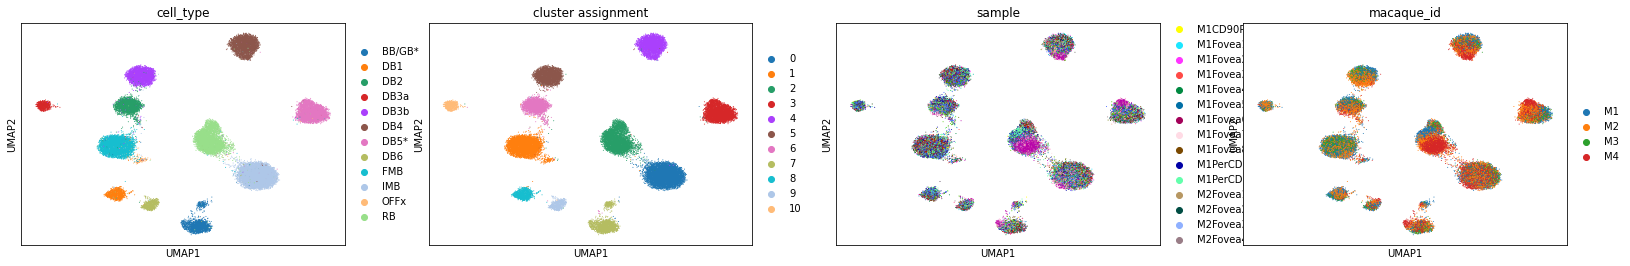

In [10]:
"""Assessing pretrained embedding"""

temporary = AnnData(deepcopy(CarDEC.dataset.obsm['precluster embedding']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Pretrained Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

## Evaluating Denoising and Batch Correction of Features

Here, we evaluate the capacity of CarDEC to denoise and batch correct features both on the zscore scale and on the original count scale. Our strategy is as follows. If genes are of high quality and reflect true cell type differences rather than enduring technical batch effects, then Louvain Clustering that is run on the normalized count matrix of these genes should be good at recovering true cell types. Then if denoising and batch correcting is working and uncovering true cell type differences, we expect that cell type clustering that uses the normalized denoised count matrix should yield higher clustering accuracy than the the original noisy counts.

To check clustering accuracy and if batch effects are present, we can evaluate our results both numerically using ARI, NMI, Purity, and visually with UMAP. Indeed, we will see exactly what we hope to see. Namely, Louvain's clustering run on the denoised features (both zscore scale and count scale) is far better than Louvain's clustering run on the raw (normalized) counts.

To get a baseline, let's cluster the original macaque data using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are very poor, suggesting that batch effects are very severe and that a more sophisticated method like CarDEC is needed to analyze cell types in this data.

Clustering original counts
ARI = 0.3444
NMI = 0.6801
Purity = 0.8869


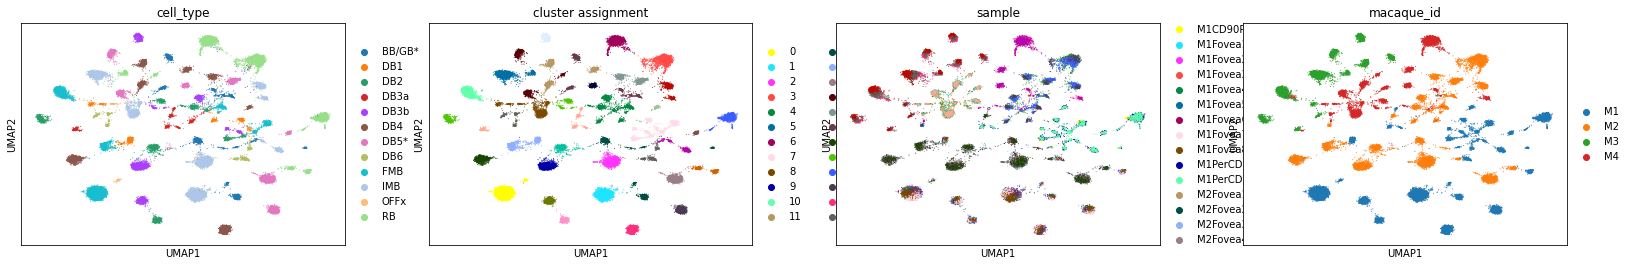

In [11]:
"""Assessing original counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.X))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering original counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

Now, let's cluster the denoised zscore scale features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are very good, suggesting that CarDEC successfully removed batch effects while preserving biological signal.

CarDEC Denoising Results using all denoised features
ARI = 0.9765
NMI = 0.9625
Purity = 0.9849


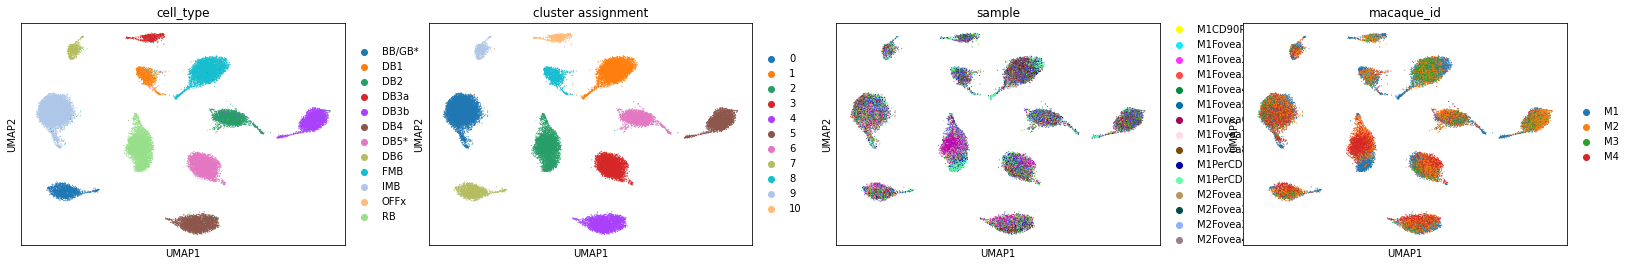

In [12]:
"""Assessing denoised zscore features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

Now, let's cluster the denoised count scale features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are very good, suggesting that CarDEC successfully removed batch effects while preserving biological signal.

CarDEC Denoising Results using all denoised counts
ARI = 0.9752
NMI = 0.9608
Purity = 0.9844


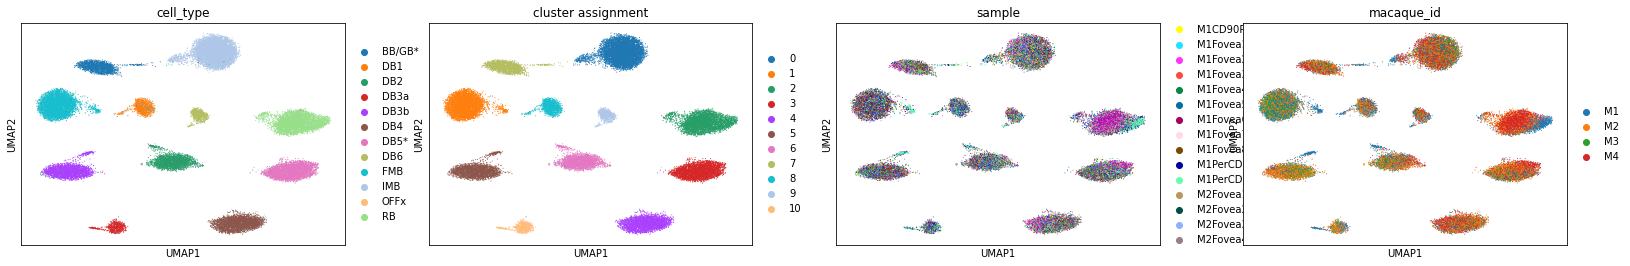

In [13]:
"""Assessing denoised Counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

## Evaluating Denoising and Batch Correction of High Variance Features

Here, we evaluate the capacity of CarDEC to denoise and batch correct high variance features specifically both on the zscore scale and on the original count scale. Our strategy is as follows.

To check clustering accuracy and if batch effects are present, we can evaluate our results both numerically using ARI, NMI, Purity, and visually with UMAP. Indeed, we will see exactly what we hope to see. Namely, Louvain's clustering run on the denoised features (both zscore scale and count scale) is far better than Louvain's clustering run on the raw (normalized) counts.

To get a baseline, let's cluster the macaque data with only high variance features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are poor, suggesting that batch effects are very severe and that a more sophisticated method like CarDEC is needed to analyze cell types in this data.

Clustering original high variance counts
ARI = 0.5178
NMI = 0.7868
Purity = 0.9534


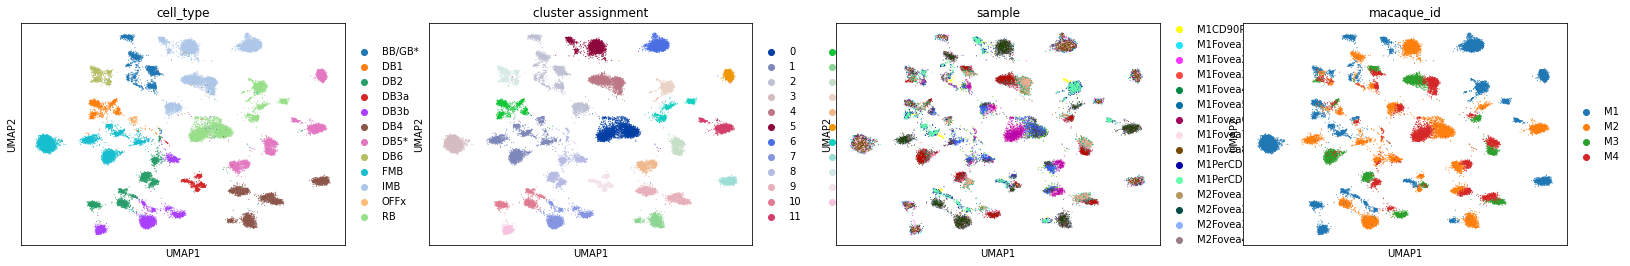

In [14]:
"""Assessing original high variance counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.X[:, CarDEC.dataset.var['Variance Type'] == 'HVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering original high variance counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))
    
"""Figure info for main paper"""
ARI_data_gene.iloc[2,:3] = ARI, NMI, Purity
ARI_raw.iloc[0,:3] = ARI, NMI, Purity

DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Macaque'] = temporary.obs['macaque_id'].values
DF['Sample'] = temporary.obs['sample'].values
DF['Region'] = temporary.obs['region'].values
DF['Cell Type'] = temporary.obs['cluster'].values
DF.index = temporary.obs.index

base_path = 'Raw_HVG.csv'
path = os.path.join(figure_path, base_path)
path_supplement = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)
DF.to_csv(path_supplement)

Now, let's consider the denoised zscore scale features obtained from the pretrained autoencoder, before finetuning to see the effect of finetuning. We cluster these denoised zscore scale high variance features using scanpy's louvain clustering workflow.

Clustering pretrained high variance features
ARI = 0.9742
NMI = 0.9590
Purity = 0.9838


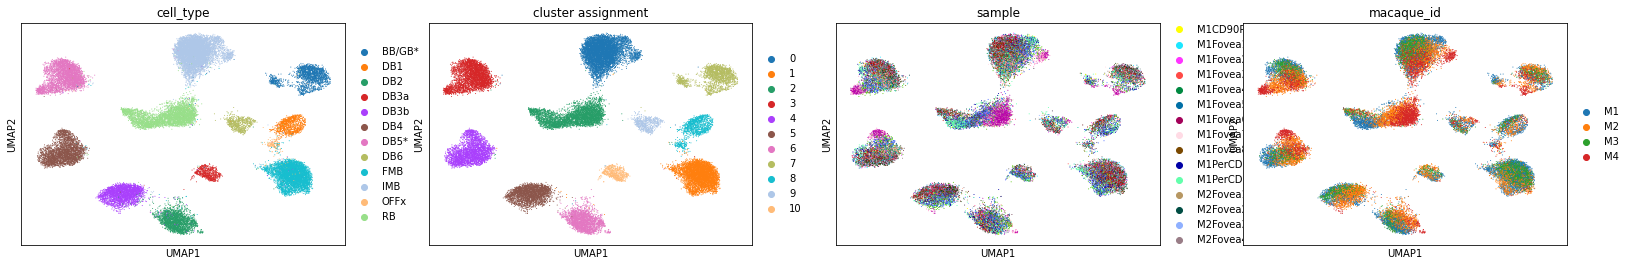

In [15]:
"""Assessing pretrained denoising of high variance features"""

temporary = AnnData(deepcopy(CarDEC.dataset.obsm['precluster denoised']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering pretrained high variance features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

Now, let's cluster the denoised zscore scale high variance features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are very good, suggesting that CarDEC successfully removed batch effects while preserving biological signal.

CarDEC high variance denoised features
ARI = 0.9758
NMI = 0.9616
Purity = 0.9845


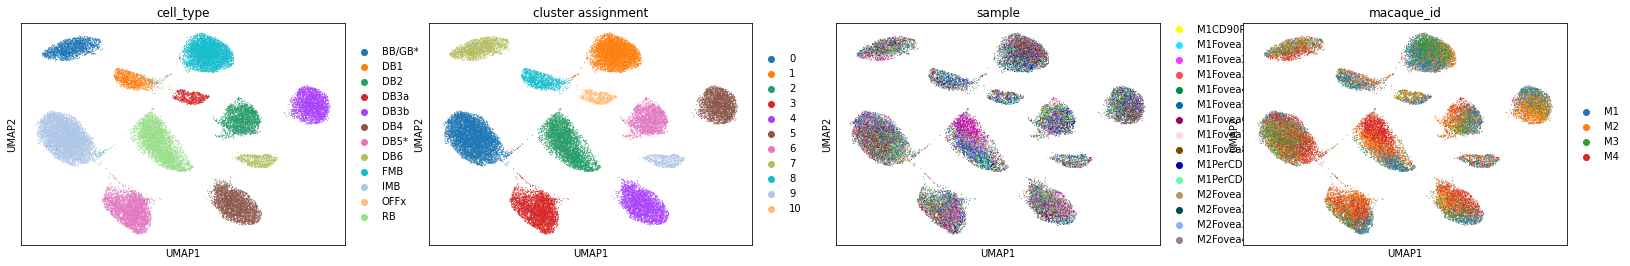

In [16]:
"""Assessing denoised zscore features for high variance features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'HVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC high variance denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

Now, let's cluster the denoised count scale high variance features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are very good, suggesting that CarDEC successfully removed batch effects while preserving biological signal.

Clustering high variance denoised counts
ARI = 0.9745
NMI = 0.9597
Purity = 0.9840


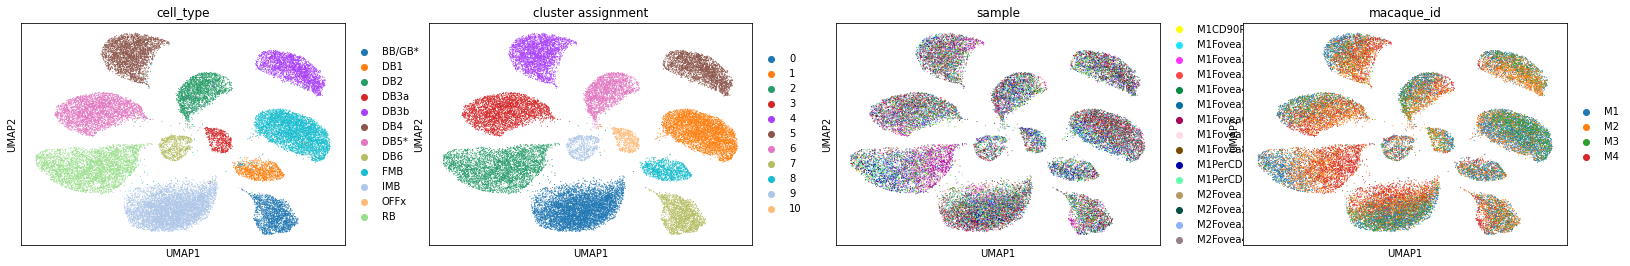

In [17]:
"""Assessing HVG denoised Counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts'][:, CarDEC.dataset.var['Variance Type'] == 'HVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering high variance denoised counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))
    
"""Figure info for main paper"""
ARI_data_gene.iloc[0,:3] = ARI, NMI, Purity
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Macaque'] = temporary.obs['macaque_id'].values
DF['Sample'] = temporary.obs['sample'].values
DF['Region'] = temporary.obs['region'].values
DF['Cell Type'] = temporary.obs['cluster'].values
DF.index = temporary.obs.index

base_path = 'CarDEC_HVG.csv'
path = os.path.join(figure_path, base_path)
path_supplement = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)
DF.to_csv(path_supplement)

## Evaluating Denoising and Batch Correction of Low Variance Features

Here, we evaluate the capacity of CarDEC to denoise and batch correct low variance features specifically both on the zscore scale and on the original count scale. Our strategy is as follows.

To check clustering accuracy and if batch effects are present, we can evaluate our results both numerically using ARI, NMI, Purity, and visually with UMAP. Indeed, we will see exactly what we hope to see. Namely, Louvain's clustering run on the denoised features (both zscore scale and count scale) is far better than Louvain's clustering run on the raw (normalized) counts.

To get a baseline, let's cluster the macaque data with only low variance features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are poor, suggesting that batch effects are very severe and that a more sophisticated method like CarDEC is needed to analyze cell types in this data.

Clustering original low variance counts
ARI = 0.1376
NMI = 0.2785
Purity = 0.4228


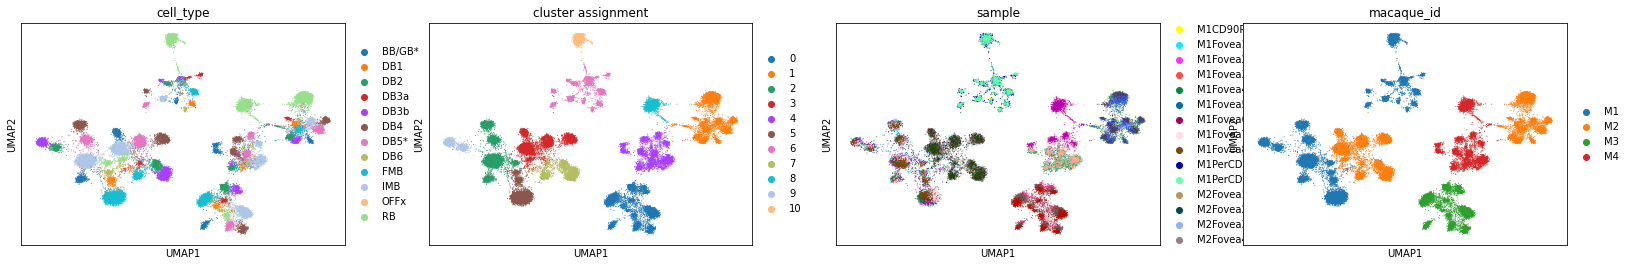

In [18]:
"""Assessing original low variance counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.X[:, CarDEC.dataset.var['Variance Type'] == 'LVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering original low variance counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))
    
"""Figure info for main paper"""
ARI_data_gene.iloc[3,:3] = ARI, NMI, Purity
ARI_raw.iloc[1,:3] = ARI, NMI, Purity
base_path = 'Raw_ARIs.csv'
path = os.path.join(figure_path, base_path)
ARI_raw.to_csv(path)

DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Macaque'] = temporary.obs['macaque_id'].values
DF['Sample'] = temporary.obs['sample'].values
DF['Region'] = temporary.obs['region'].values
DF['Cell Type'] = temporary.obs['cluster'].values
DF.index = temporary.obs.index

base_path = 'Raw_LVG.csv'
path = os.path.join(figure_path, base_path)
path_supplement = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)
DF.to_csv(path_supplement)

Now, let's cluster the denoised zscore scale low variance features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are very good, suggesting that CarDEC successfully removed batch effects while preserving biological signal.

Clustering low variance denoised features
ARI = 0.9682
NMI = 0.9522
Purity = 0.9631


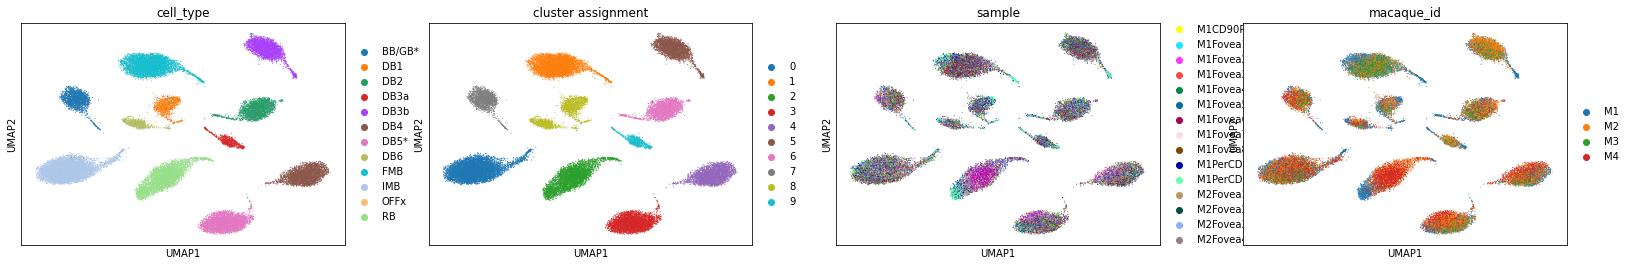

In [19]:
"""Assessing denoised zscore features for low variance features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised'][:, CarDEC.dataset.var['Variance Type'] == 'LVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering low variance denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

Now, let's cluster the denoised count scale low variance features using scanpy's louvain clustering workflow. We see that all three clustering accuracy metrics are very good, suggesting that CarDEC successfully removed batch effects while preserving biological signal.

Clustering low variance denoised counts
ARI = 0.9740
NMI = 0.9581
Purity = 0.9832


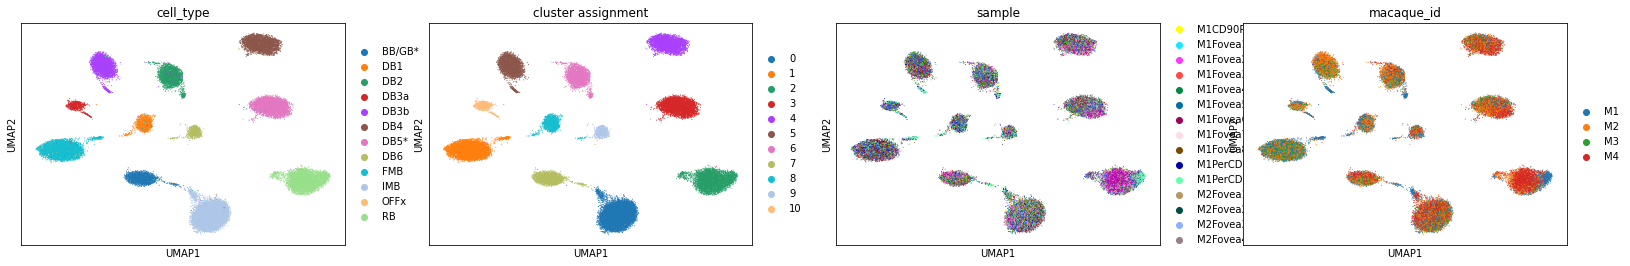

In [20]:
"""Assessing LVG denoised Counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts'][:, CarDEC.dataset.var['Variance Type'] == 'LVG']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("Clustering low variance denoised counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))
    
"""Figure info for main paper"""
ARI_data_gene.iloc[1,:3] = ARI, NMI, Purity
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Macaque'] = temporary.obs['macaque_id'].values
DF['Sample'] = temporary.obs['sample'].values
DF['Region'] = temporary.obs['region'].values
DF['Cell Type'] = temporary.obs['cluster'].values
DF.index = temporary.obs.index

base_path = 'CarDEC_LVG.csv'
path = os.path.join(figure_path, base_path)
path_supplement = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)
DF.to_csv(path_supplement)

ARI_data_gene.to_csv(os.path.join(figure_path, 'genespaceARIs.csv'))
ARI_data_gene.to_csv(os.path.join(figure_path_supplement, 'genespaceARIs.csv'))

## Potential Question: Why not just model all genes as highly variable?

Retort: Including all genes as highly variable features which can affect CarDEC's cluster assignments sometimes leads to poor clustering results. In this dataset, the special architecture is not needed as CarDEC can overcome batch effects on this dataset even if all genes are treated as highly variable. However on other datasets like the pancreas, cortex, and liver data, we have observed that this architecture is needed to preserve CarDEC's performance when modeling low variance features. Aso note that results on the count scale aren't great with this naive model.

Let's explore the performance of CarDEC when treating all genes as highly variable. First, initialze the CarDEC API, build the model, make inference, and get denoised counts.

In [21]:
CarDEC = CarDEC_API(adata, weights_dir = "Macaque All/CarDEC_All Gene Weights", batch_key = "sample",
                    n_high_var = None, LVG = False)

/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xiaokangyu/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: Use

In [22]:
CarDEC.build_model(n_clusters = 11)


-----------------------CarDEC Architecture-----------------------


--------------------Encoder Sub-Architecture--------------------

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [1, 1, 128]       2,314,752
              ReLU-2                [1, 1, 128]               0
            Linear-3                 [1, 1, 32]           4,128
              Tanh-4                 [1, 1, 32]               0
Total params: 2,318,880
Trainable params: 2,318,880
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.07
Forward/backward pass size (MB): 0.00
Params size (MB): 8.85
Estimated Total Size (MB): 8.92
----------------------------------------------------------------

------------------Base Decoder Sub-Architecture------------------

----------------------------------------------------------------
        Layer (type)      

KeyboardInterrupt: 

In [ ]:
CarDEC.make_inference()

In [ ]:
CarDEC.model_counts()

Now, let's assess the performance of this model for clustering.

In [ ]:
"""Assessing finetuned cluster assignments"""

temporary = AnnData(CarDEC.dataset.obsm['embedding'])
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

q = CarDEC.dataset.obsm['cluster memberships']
labels = np.argmax(q, axis=1)
temporary.obs['cluster assignment'] = [str(x) for x in labels]

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

We can also assess the performance of this framework for producing denoised features in the gene space on the zscore scale.

In [ ]:
"""Assessing denoised zscore features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised features")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

We can also assess the performance of this framework for producing denoised features in the gene space on the count scale.

In [ ]:
"""Assessing denoised Counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

## Potential Question: By modeling low variance genes through the introduction of millions of parameters, does CarDEC compromise performance on high variance genes?

Retort: Our special architecture is explicitly designed to maintain maximal performance on the high variance features even when modeling low variance features as well. To demonstrate this, let's fit CarDEC only with highly variable features and demonstrate that the model does not do any better at clustering and denoising highly variable features than the HVG/LVG CarDEC model that also models low variance features.

Let's explore the performance of CarDEC when modeling only the highly variable genes. First, initialze the CarDEC API, build the model, make inference, and get denoised counts.

In [ ]:
ARI_HVGo_gene = {'ARI': [0] * 1,
            'NMI': [0] * 1,
            'Purity': [0] * 1,
           'Method': ['CarDEC']}
ARI_HVGo_gene = pd.DataFrame(ARI_HVGo_gene)

In [ ]:
CarDEC = CarDEC_API(adata, weights_dir = "Macaque All/CarDEC_HVG Weights", batch_key = "sample",
                    n_high_var = 2000, LVG = False)

In [ ]:
CarDEC.build_model(n_clusters = 11)

In [ ]:
CarDEC.make_inference()

In [ ]:
CarDEC.model_counts()

First, let's demonstrate that we maintain excellent clustering performance by computing clustering accuracy from the outputed membership probabilities and examining the UMAP output. As we can see, this HVG model does no better at clustering than our HVG/LVG model.

In [ ]:
"""Assessing finetuned cluster assignments"""

temporary = AnnData(CarDEC.dataset.obsm['embedding'])
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

q = CarDEC.dataset.obsm['cluster memberships']
labels = np.argmax(q, axis=1)
temporary.obs['cluster assignment'] = [str(x) for x in labels]

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Clustering Results")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

Also, let's verify that our HVG/LVG model denoises highly variable genes on the zscore scale just as well as the HVG only model. We can do this by running Louvain clustering on the denoised counts outputted by the HVG model and demonstrating that the clustering is no better than the HVG/LVG model both quantitatively (ARI, NMI, Purity) and visually (UMAP).

In [ ]:
"""Assessing denoised zscore features"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]

print("CarDEC Denoising Results using all denoised counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))

Also, let's verify that our HVG/LVG model denoises highly variable genes on the count scale just as well as the HVG only model. We can do this by running Louvain clustering on the denoised counts outputted by the HVG model and demonstrating that the clustering is no better than the HVG/LVG model both quantitatively (ARI, NMI, Purity) and visually (UMAP).

In [ ]:
"""Assessing denoised Counts"""

temporary = AnnData(deepcopy(CarDEC.dataset.layers['denoised counts']))
temporary.obs = CarDEC.dataset.obs
temporary.obs['cell_type'] = temporary.obs['cluster']

sc.pp.normalize_total(temporary)
sc.pp.log1p(temporary)
sc.pp.scale(temporary)

sc.tl.pca(temporary, svd_solver='arpack')
sc.pp.neighbors(temporary, n_neighbors = 15)

res = find_resolution(temporary, 11)
sc.tl.louvain(temporary, resolution = res)
temporary.obs['cluster assignment'] = temporary.obs['louvain']

sc.tl.umap(temporary)
sc.pl.umap(temporary, color = ["cell_type", "cluster assignment", "sample", "macaque_id"], return_fig = True)

ARI, NMI, Purity = [metric(temporary.obs['cell_type'], temporary.obs['cluster assignment']) for metric in metrics_]
"""Figure info for paper"""
ARI_HVGo_gene.iloc[0,:3] = ARI, NMI, Purity
DF = pd.DataFrame(temporary.obsm['X_umap'])
DF.columns = ['UMAP1', 'UMAP2']
DF['Macaque'] = temporary.obs['macaque_id'].values
DF['Sample'] = temporary.obs['sample'].values
DF['Region'] = temporary.obs['region'].values
DF['Cell Type'] = temporary.obs['cluster'].values
DF.index = temporary.obs.index

base_path = 'CarDEC_HVGOnly.csv'
path = os.path.join(figure_path_supplement, base_path)

DF.to_csv(path)
ARI_HVGo_gene.to_csv(os.path.join(figure_path_supplement, 'genespaceARIs_HVGo.csv'))

print("CarDEC Denoising Results using all denoised counts")
print ("ARI = {0:.4f}".format(ARI)) 
print ("NMI = {0:.4f}".format(NMI)) 
print ("Purity = {0:.4f}".format(Purity))